In [334]:
from typing import List
from math import sqrt
import numpy as np
from scipy.sparse.linalg import norm
from scipy.constants import pi
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import cirq
import openfermion as of
from kcommute import get_si_sets
from convert import to_groups_of

In [335]:
def bound(d, chi, zeta, gamma0p, h_norm, delta, deltap, big_deltap):
    if deltap > big_deltap:
        t0 = deltap
    else:
        t0 = 0.0
    t1 = chi / gamma0p
    c = 6.0 * h_norm / gamma0p
    p0 = chi / (deltap - delta)
    p1 = 8.0 * ((1.0 + (pi * delta) / (2.0 * h_norm)) ** (-2 * d))
    return t0 + t1 + c * (p0 + zeta + p1)

In [336]:
def first_order_comm_norm(
    groups: List[of.QubitOperator],
    nq: int
) -> float:
    """Norm of commutators from first-order Trotter bound in ToTECS Proposition 9.

    Arguments:
    groups: A list of qubit operators. Each represents a term in the Trotter expansion.

    Returns:
    Sum of commutator norms from Prop. 9."""

    # Evaluate sum_gamma1 ||[\sum_gamma2 H_gamma2, H_gamma1]||
    comm_norms = 0.0 # = sum_gamma1 ||\sum_gamma2 [H_gamma2, H_gamma1]||
    for i1 in range(len(groups)):
        total_commutator = of.QubitOperator() # = \sum_gamma2 [H_gamma2, H_gamma1]
        for i2 in range(i1 + 1, len(groups)):
            total_commutator += groups[i2] * groups[i1] - groups[i1] * groups[i2]
        tc_matrix = of.linalg.qubit_operator_sparse(total_commutator, nq)
        comm_norms += norm(tc_matrix, ord=2)
    return comm_norms


def s_dist_bound(d: int, tau: float, r: int, comm_norm: float) -> float:
    """Upper bound on ||S-S'|| from Trotter error.
    
    Arguments:
    d - subspace dimension.
    tau - evolution time
    r - number of time steps.
    comm_norm - sum of commutator norms.
    
    Returns:
    upper bound on ||S-S'||."""

    return d ** 2 * tau ** 2 / (sqrt(2.0) * r) * comm_norm

In [342]:
l = 2
t = 1.0
u = 2.0
ham_fermi = of.hamiltonians.fermi_hubbard(l, l, t, u, spinless=True)
ham = of.transforms.jordan_wigner(ham_fermi)
nq = of.utils.count_qubits(ham)
ham_cirq = of.transforms.qubit_operator_to_pauli_sum(ham)
groups = [[p] for p in ham_cirq]
groups_of = to_groups_of(groups)
comm_norm = first_order_comm_norm(groups_of, nq)
h_norm = norm(of.linalg.get_sparse_operator(ham))
print(f"h_norm = {h_norm}")

big_delta = 3.23
gamma0 = 0.99

tau = 0.1
d = 16
steps = range(10, 300)

s_distances = []
chis = []
bounds = []
for step in steps:
    s_distance = s_dist_bound(d, tau, step, comm_norm)
    s_distances.append(s_distance)
    chi = 2.0 * h_norm * s_distance
    chis.append(chi)
    eps = s_distance
    zeta = 2.0 * d * (eps + s_distance)
    gamma0_p = gamma0 - 2 * eps - 2.0 * s_distance
    big_deltap = big_delta - chi / gamma0_p

    def bound_callback(v):
        """Evaluates bound for v=(delta, deltap)"""
        return bound(d, chi, zeta, gamma0_p, h_norm, v[0], v[1], big_deltap)
    
    def delta_constraint(v):
        if big_deltap > 0.0:
            return big_deltap - v[1]
        else:
            return big_delta - v[1]

    if big_deltap > 0:
        v0 = np.array([big_deltap / 2, big_deltap])
    else:
        v0 = np.array([big_delta / 2, big_delta])
    result = minimize(
        bound_callback, 
        v0,
        constraints=(
            {'type': 'ineq', 'fun': lambda v: v[1] - v[0] - chi / gamma0_p},
            {'type': 'ineq', 'fun': lambda v: v[0]},
            {'type': 'ineq', 'fun': lambda v: v[1]},
            {'type': 'ineq', 'fun': delta_constraint}
        ),
        method="COBYLA"
    )
    if not result.success:
        print(f"step = {step} did not succeed.")
    bounds.append(result.fun)

h_norm = 13.2664991614216
step = 182 did not succeed.
step = 183 did not succeed.
step = 184 did not succeed.
step = 185 did not succeed.
step = 186 did not succeed.
step = 187 did not succeed.
step = 188 did not succeed.
step = 189 did not succeed.
step = 190 did not succeed.
step = 191 did not succeed.
step = 192 did not succeed.
step = 193 did not succeed.
step = 194 did not succeed.
step = 195 did not succeed.
step = 196 did not succeed.
step = 197 did not succeed.
step = 198 did not succeed.
step = 199 did not succeed.
step = 200 did not succeed.
step = 201 did not succeed.
step = 202 did not succeed.
step = 203 did not succeed.
step = 204 did not succeed.
step = 205 did not succeed.
step = 206 did not succeed.
step = 207 did not succeed.
step = 208 did not succeed.
step = 209 did not succeed.
step = 210 did not succeed.
step = 211 did not succeed.
step = 212 did not succeed.
step = 213 did not succeed.
step = 214 did not succeed.
step = 215 did not succeed.
step = 216 did not suc

In [343]:
print(np.min(bounds))
print(np.max(bounds))

-350562330.2550795
6.423277021163284e+113


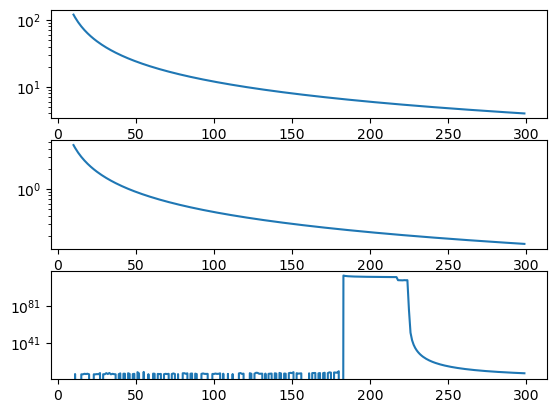

In [344]:
fig, axs = plt.subplots(3, 1)
for ax in axs:
    ax.set_yscale("log")
axs[0].plot(steps, chis)
axs[1].plot(steps, s_distances)
axs[2].plot(steps, bounds)